In [33]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from string import punctuation
import nltk
from nltk import word_tokenize
from nltk import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

get_ipython().system('pip install Unidecode')
import unidecode
import re
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from PIL import Image

[nltk_data] Downloading package punkt to /Users/Antoine/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Antoine/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Antoine/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Data importation

In [2]:
df = pd.read_json('automobile_propre_top10_forums.json')
print(df.shape)
df.head(2)

(398199, 6)


,marque,sous_marque,forum_id,forum_name,date,text
0,Dacia,Dacia Spring,38723,Mise à jour de la cartographie pour la navigation,2021-12-04 19:06:48,[\nJ'ai fait la mise à jour de la cartographie...
1,Dacia,Dacia Spring,40101,Application My Dacia abonnement payant à prévoir?,2022-01-16 11:55:46,"[\nBonjour \n, \nDésolé pour le titre un peut ..."


# Data exploration

## Features' types

In [3]:
df.describe()

,forum_id
count,398199.000000
mean,19771.718884
std,8008.774423
min,39.000000
25%,13393.000000
50%,17451.000000
75%,26096.000000
max,40212.000000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398199 entries, 0 to 398198
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   marque       398199 non-null  object        
 1   sous_marque  398199 non-null  object        
 2   forum_id     398199 non-null  int64         
 3   forum_name   398199 non-null  object        
 4   date         398199 non-null  datetime64[ns]
 5   text         398199 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 21.3+ MB


In [6]:
for col in df.columns:
    print("type of first element of", col, ":", type(df[col][0]))

type of first element of marque : <class 'str'>
type of first element of sous_marque : <class 'str'>
type of first element of forum_id : <class 'numpy.int64'>
type of first element of forum_name : <class 'str'>
type of first element of date : <class 'pandas._libs.tslibs.timestamps.Timestamp'>
type of first element of text : <class 'list'>
type of first element of joined_comment : <class 'str'>


## Brand

In [7]:
# Number of comment by brand
print('Total number of comments : {}'.format(len(df)))
print('Number of brand : {}'.format(df.sous_marque.nunique()))

Total number of comments : 398199
Number of brand : 10


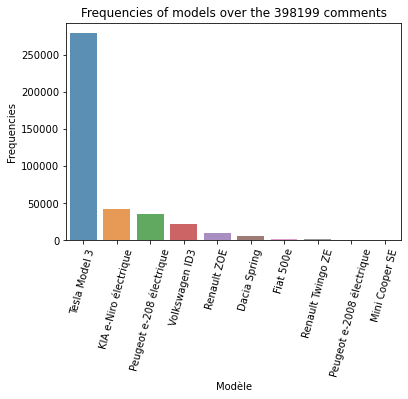

In [8]:
# Plotting brand distribution
X_models = df.sous_marque.value_counts()
ax = sns.barplot(x=X_models.index, y=X_models, alpha=0.8)
ax.set(xlabel='Modèle', ylabel='Frequencies', title='Frequencies of models over the {} comments'.format(df.shape[0]))
plt.xticks(rotation=75)
plt.show()

## Words per comment

Some stats about number of words : 
count    398199.000000
mean         62.545423
std          70.298362
min           0.000000
25%          21.000000
50%          43.000000
75%          80.000000
max        4225.000000
Name: n_words, dtype: float64


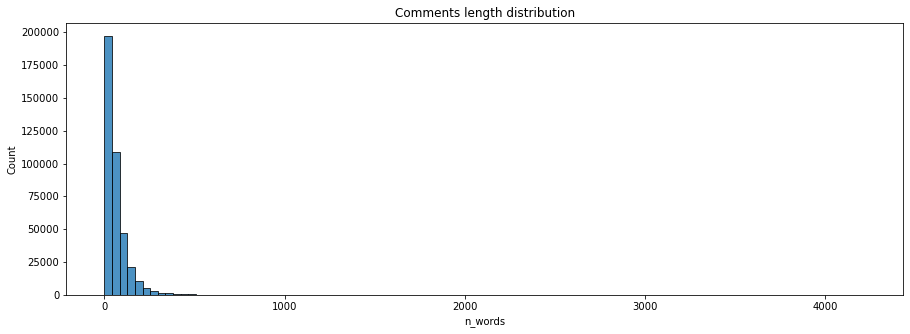

In [9]:
# Info on the number of words per comment
df["n_words"] = df['joined_comment'].str.split().apply(len).astype(int)
print('Some stats about number of words : \n{}'.format(df.n_words.describe()))

fig, ax = plt.subplots(figsize=(15, 5))
sns.histplot(df['n_words'], bins=100, alpha=0.8)
plt.title('Comments length distribution')
plt.show()

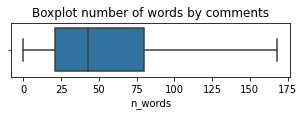

In [14]:
fig, ax = plt.subplots(figsize=(5, 1))
sns.boxplot(x=df['n_words'], showfliers=False)
plt.title('Boxplot number of words by comments')
plt.show()

# Data preprocessing

In [5]:
df["sous_marque"] = df["sous_marque"].astype(str)
df["joined_comment"] = df['text'].apply(lambda list_text: " ".join(list_text))
df.head(2)

,marque,sous_marque,forum_id,forum_name,date,text,joined_comment
0,Dacia,Dacia Spring,38723,Mise à jour de la cartographie pour la navigation,2021-12-04 19:06:48,[\nJ'ai fait la mise à jour de la cartographie...,\nJ'ai fait la mise à jour de la cartographie ...
1,Dacia,Dacia Spring,40101,Application My Dacia abonnement payant à prévoir?,2022-01-16 11:55:46,"[\nBonjour \n, \nDésolé pour le titre un peut ...","\nBonjour \n \nDésolé pour le titre un peut ""p..."


In [21]:
# One corpus correspond to one car sub-brand
corpus = df[['sous_marque','joined_comment']].groupby("sous_marque")["joined_comment"].apply(lambda x: " ".join(x))
corpus = corpus.to_list()
corpus[0][:200]

'\nJ\'ai fait la mise à jour de la cartographie comme indiqué sur la vidéo " ".\n \nMais une fois l\'opération effectuée, l\'écran dit que tous les fichiers sont à jour au 4ème trimestre 2020. Autrement dit '

In [20]:
# To lower
corpus_l = [comment.lower() for comment in corpus]
corpus_l[0][:200]

'\nj\'ai fait la mise à jour de la cartographie comme indiqué sur la vidéo " ".\n \nmais une fois l\'opération effectuée, l\'écran dit que tous les fichiers sont à jour au 4ème trimestre 2020. autrement dit '

In [22]:
# Remove punctuation
characters_to_remove = ["@", "/", "#", ".", ",", "!", "?", "(", ")", "-", "_","’","'", "\"", ":"]
transformation_dict = {initial:" " for initial in characters_to_remove}
no_punctuation_corpus = [comment.translate(str.maketrans(transformation_dict)) for comment in corpus_l]
no_punctuation_corpus[0][:200]

'\nj ai fait la mise à jour de la cartographie comme indiqué sur la vidéo     \n \nmais une fois l opération effectuée  l écran dit que tous les fichiers sont à jour au 4ème trimestre 2020  autrement dit '

In [24]:
# Remove accent
no_accent_corpus = [unidecode.unidecode(comment) for comment in no_punctuation_corpus]
no_accent_corpus[0][:200]

'\nj ai fait la mise a jour de la cartographie comme indique sur la video     \n \nmais une fois l operation effectuee  l ecran dit que tous les fichiers sont a jour au 4eme trimestre 2020  autrement dit '

In [25]:
# Remove specific characters
clean_corpus = [comment.replace("\n", "").replace("\xa0", "") for comment in no_accent_corpus]
clean_corpus[0][:200]

'j ai fait la mise a jour de la cartographie comme indique sur la video      mais une fois l operation effectuee  l ecran dit que tous les fichiers sont a jour au 4eme trimestre 2020  autrement dit ils'

In [30]:
# We find the most common words
# They are probably undifferentiating and can be added to the stop_words list. 
list_words = []

# split() returns list of all the words in the string
for doc in clean_corpus:
    split_it = doc.split()
    # Pass the split_it list to instance of Counter class.
    counter = Counter(split_it)
  
    # most_common() produces k frequently encountered
    # input values and their respective counts.
    most_occur = counter.most_common(60)
    df_most_occur = pd.DataFrame(most_occur)
    list_words += list(df_most_occur.iloc[:,0])
    
for word in ['spring', 'charge', 'batterie', 'recharge', 'electrique', 'prix', 'cable', 'vw', 'merci',
             'km', 'temps', 'jour', 'probleme', 'borne', 'puissance', 'autonomie', 'kw', 'bien', 'location']:
    if word in list_words:
        list_words.remove(word)

print(len(list_words))
list_words[:20]

589


['de',
 'la',
 'a',
 'le',
 'est',
 'et',
 'en',
 'pas',
 'pour',
 'je',
 'l',
 'que',
 'les',
 'un',
 'une',
 'sur',
 'd',
 'il',
 'j',
 'des']

# Tokenization

In [31]:
def preprocessing(sentence):
    """ Basic processing of a document, word by word. 
    Outputs a list of processed tokens
    """
    # Tokenization
    tokens = word_tokenize(sentence)
    
    # stopwords + lowercase
    tokens = [token.lower() for token in tokens if token.lower() not in stop_char]
    
    Lemmatizer = WordNetLemmatizer()
    
    tokens = [Lemmatizer.lemmatize(token) for token in tokens]
    
    # Deleting words with only one caracter
    tokens = [token for token in tokens if len(token)>2]
    
    return tokens

In [32]:
# Tokenization
stop_words = nltk.corpus.stopwords.words("french")
stop_char = stop_words + list(punctuation) + list_words

tokenized_corpus = []

for sent in clean_corpus:
    if len(sent)>0:
        tokenized_corpus.append(preprocessing(sent))
        
print("Number of corpus after cleaning:", len(tokenized_corpus))

Number of corpus after cleaning: 10


# Vectorization & TF-IDF matrix

In [34]:
corpus_clean = [' '.join(sentence) for sentence in tokenized_corpus]

vectorizer = TfidfVectorizer(stop_words=stop_words)
vect_corpus = vectorizer.fit_transform(corpus_clean)
feature_names = np.array(vectorizer.get_feature_names())

# TF-IDF
df_tfidf = pd.DataFrame(vect_corpus.todense(), columns = feature_names)
df_tfidf_mean = df_tfidf.mean().sort_values(ascending=False).to_frame(name='tfidf mean')
dict_words_tfidf = df_tfidf_mean[df_tfidf_mean['tfidf mean'] != 0].to_dict()['tfidf mean']

# Wordcloud on the whole dataset

In [36]:
wordcloud = WordCloud(height=600, width=800, background_color="white", colormap='inferno', max_words=100)
wordcloud.generate_from_frequencies(frequencies=dict_words_tfidf)

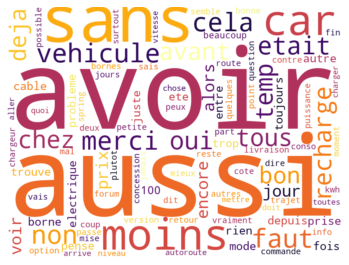

In [39]:
plt.figure(figsize=(6, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Wordcloud per sub-brand

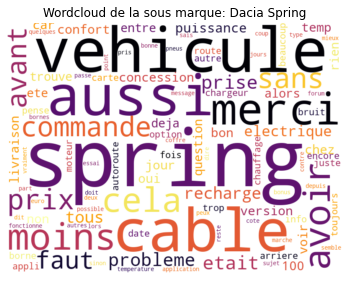

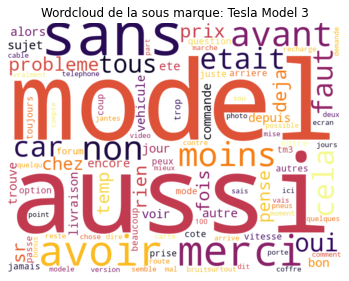

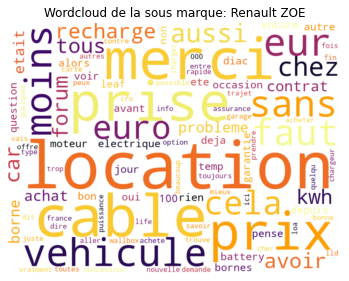

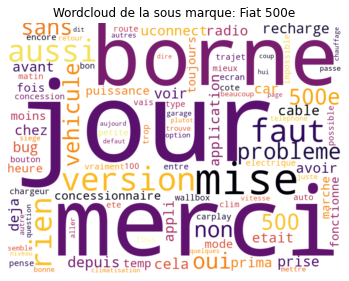

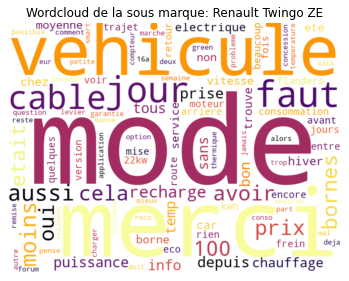

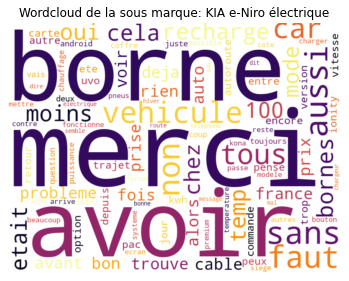

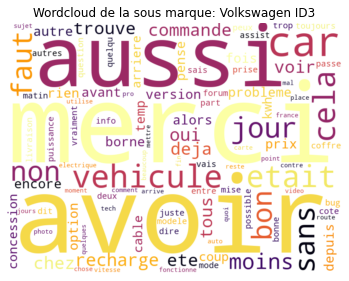

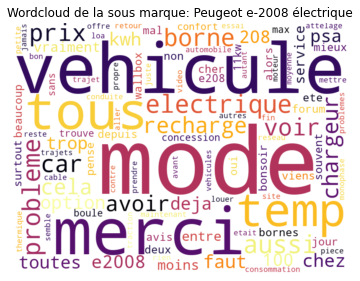

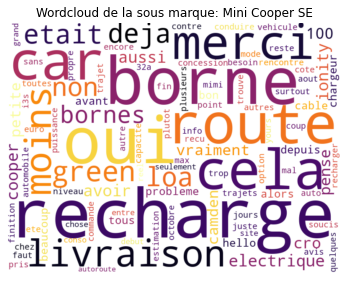

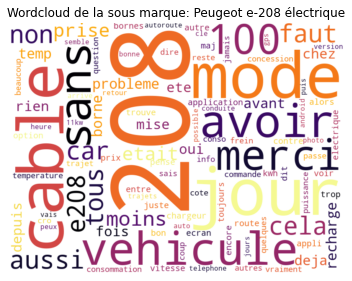

In [40]:
for sous_marque in df["sous_marque"].unique():
    corpus_marque = df[df["sous_marque"]==sous_marque].groupby("forum_id")["joined_comment"].apply(lambda x: " ".join(x))
    corpus_marque = corpus_marque.to_list()
    corpus_marque_l = [comment.lower() for comment in corpus_marque]
    no_punctuation_corpus_marque = [comment.translate(str.maketrans(transformation_dict)) for comment in corpus_marque_l]
    no_accent_corpus_marque = [unidecode.unidecode(comment) for comment in no_punctuation_corpus_marque]
    clean_corpus_marque = [comment.replace("\n", "").replace("\xa0", "") for comment in no_accent_corpus_marque]
    tokenized_corpus_marque = [preprocessing(document) for document in clean_corpus_marque]
    
    vectorizer = TfidfVectorizer(stop_words=stop_words)
    corpus_final_marque = [' '.join(sentence) for sentence in tokenized_corpus_marque]
    vect_corpus_marque = vectorizer.fit_transform(corpus_final_marque)
    feature_names = np.array(vectorizer.get_feature_names())
    
    df_tfidf = pd.DataFrame(vect_corpus_marque.todense(), columns = feature_names)
    df_tfidf_mean = df_tfidf.mean().sort_values(ascending=False).to_frame(name='tfidf mean')
    dict_words_tfidf = df_tfidf_mean[df_tfidf_mean['tfidf mean'] != 0].to_dict()['tfidf mean']
    
    wordcloud = WordCloud(height=600, width=800, background_color="white", colormap='inferno', max_words=100)
    wordcloud.generate_from_frequencies(frequencies=dict_words_tfidf)
    
    plt.figure(figsize=(6, 8))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("Wordcloud de la sous marque: {}".format(sous_marque))
    plt.show()